0. Load Module

In [3]:
# Load Module
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchinfo import summary
from torchmetrics.functional.classification import multiclass_accuracy

1. Load Data

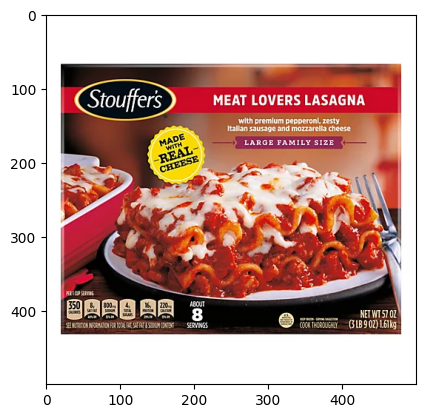

In [4]:
# 1. Load Data
file_dir = '../imgs'
not_pizza_dir = '../imgs/not_pizza/'
pizza_dir = '../imgs/pizza'

for img in os.listdir(not_pizza_dir):
    img = os.path.join(not_pizza_dir, img)
    img = plt.imread(img)
    plt.imshow(img)
    plt.show()
    break   # 잘 출력된다

2. 전처리  
2-1. 오류 없는 파일만 저장

In [5]:
# 오류 없는 이미지 파일명 리스트 생성
not_pizza_list, pizza_list = [], []

for img in os.listdir(not_pizza_dir):
    try:
        img = os.path.join(not_pizza_dir, img)
        img = plt.imread(img)
        not_pizza_list.append(img)
    except:
        continue
for img in os.listdir(pizza_dir):
    try:
        img = os.path.join(pizza_dir, img)
        img = plt.imread(img)
        pizza_list.append(img)
    except:
        continue

print(len(not_pizza_list), len(pizza_list))    # 945 945

945 945


Shape 평균 및 최소값으로 resize 크기 선정

In [6]:
Shapes1, Shape2 = [], []
for img in not_pizza_list:
    Shapes1.append(img.shape)
print(np.mean(Shapes1, axis=0), np.min(Shapes1, axis=0))
for img in pizza_list:
    Shape2.append(img.shape)
print(np.mean(Shape2, axis=0), np.min(Shape2, axis=0))

[511.28677249 557.85291005   3.0021164 ] [153 248   3]
[466.58835979 489.79153439   3.        ] [127 287   3]


데이터셋 생성(ImageFolder) 및 분리, DataLoader 생성

In [7]:
# Shape 통일
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 전체 이미지 변환 : ImageFolder
total_dataset = ImageFolder(root=file_dir, transform=transform)

label_list = []
img_count = 0
for img, label in total_dataset:
    img_count += 1
    label_list.append(label)

# 2. Split Data
from torch.utils.data import random_split
ratios = [0.8, 0.1, 0.1]

train_dataset, valid_dataset, test_dataset = random_split(total_dataset, ratios, generator=torch.Generator().manual_seed(11))

# DataLoader : Batch Size = 32
train_loader = DataLoader(train_dataset, batch_size=32, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, drop_last=True)


모델 선언 및 fc(fully connected) layer 추가

In [8]:
# Model : ResNet18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
print(num_ftrs) # 512
model.fc = nn.Linear(num_ftrs, 1)   # 512, 1

512


fc 반영된 모델 : 뭘 바꿀 수 있을까?

In [9]:
# ResNet(
#   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (relu): ReLU(inplace=True)
#   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#   (layer1): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (layer2): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (downsample): Sequential(
#         (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
#         (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (layer3): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (downsample): Sequential(
#         (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
#         (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (layer4): Sequential(
#     (0): BasicBlock(
#       (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (downsample): Sequential(
#         (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
#         (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       )
#     )
#     (1): BasicBlock(
#       (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#       (relu): ReLU(inplace=True)
#       (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#       (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     )
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
#   (fc): Linear(in_features=512, out_features=1, bias=True)
# )

Make Dot

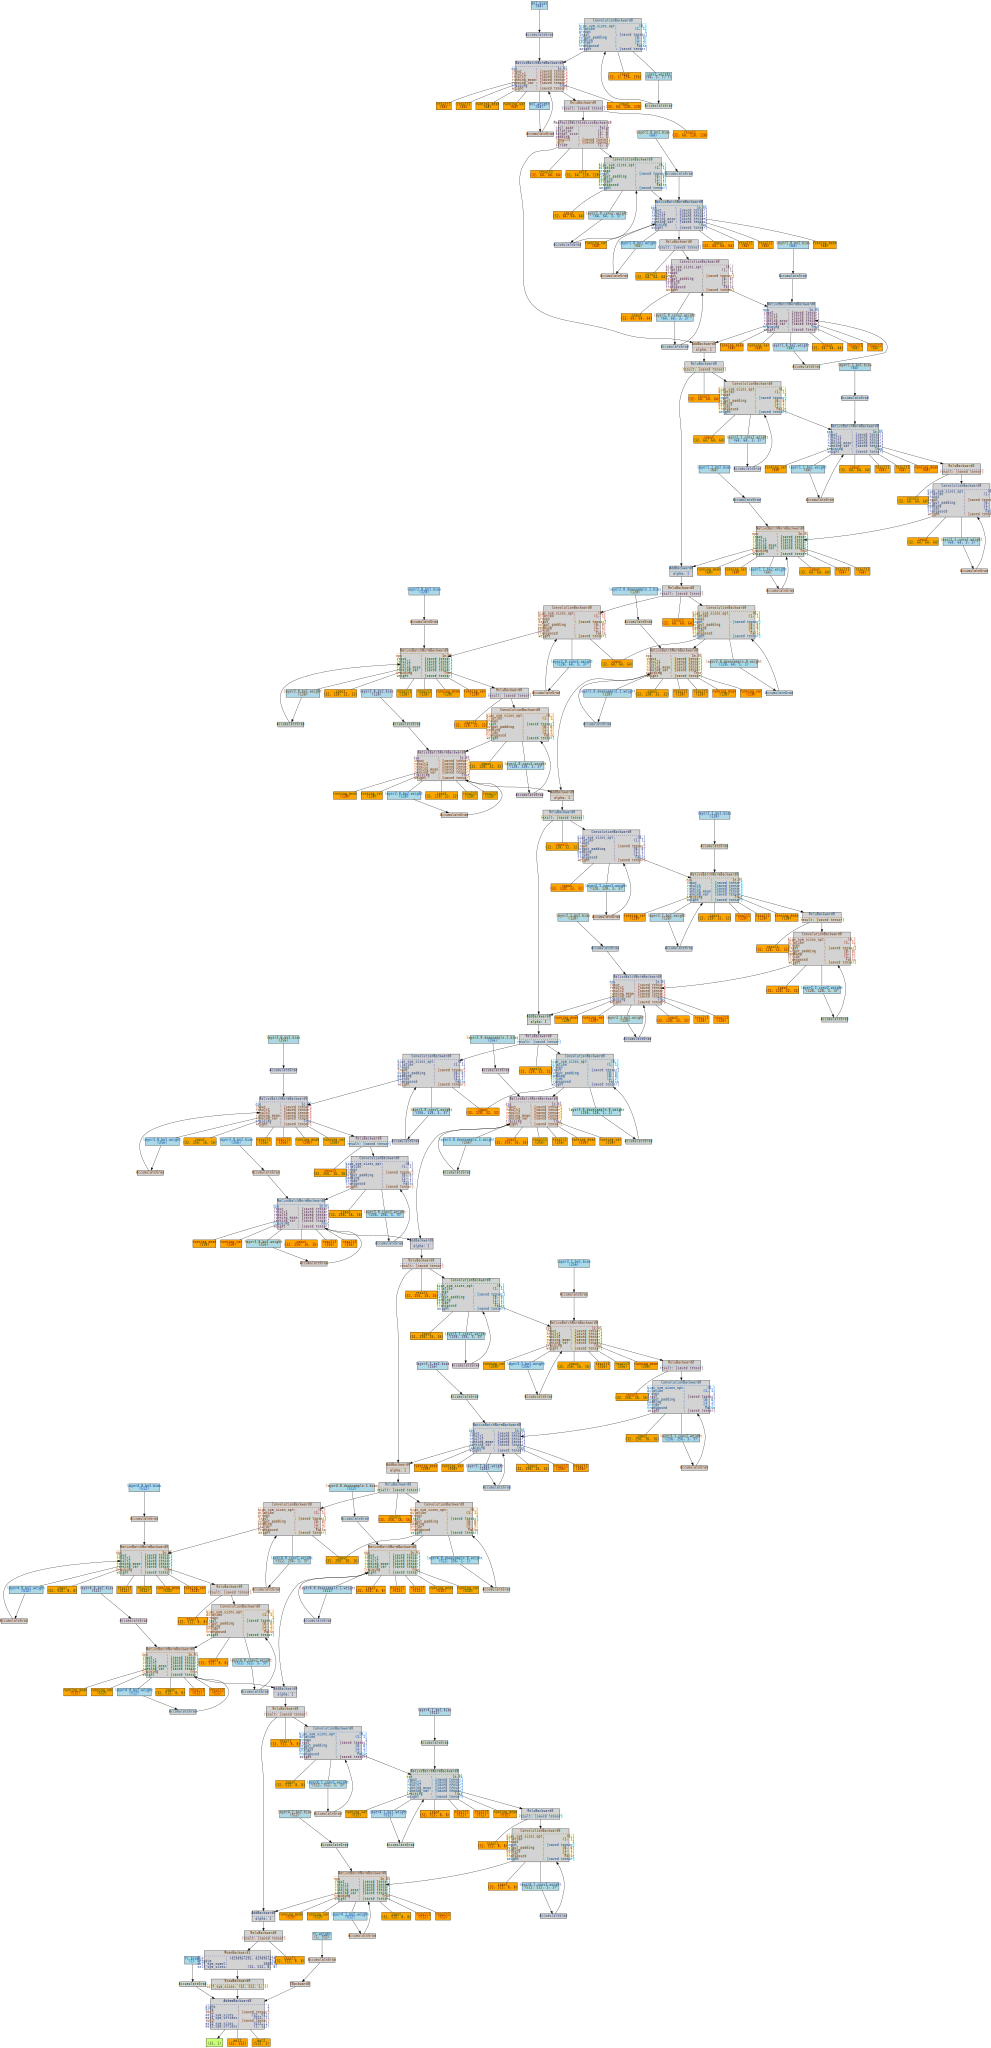

In [10]:
# makedot
from torchviz import make_dot

make_dot(model(torch.randn(32, 3, 256, 256)), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

모델 학습 및 평가

In [11]:
# 학습 준비
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
Epochs = 5


In [12]:

# 학습
loss_list, acc_list = [], []
for epoch in range(Epochs):
    model.train()
    for i, (imgs, labels) in enumerate(train_loader):
        
        preds = model(imgs)
        label = labels.unsqueeze(1).float()
        loss = criterion(preds, label)
        
        loss_list.append(loss.item())

        optimizer.zero_grad()   # gradient 초기화
        loss.backward()     # backward
        optimizer.step()    # weight update

        
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{Epochs}], Step [{i+1}/{len(train_loader)}], Loss : {loss.item()}')


    scheduler.step(loss.item())
    if scheduler.state_dict()['_last_lr'][0] < 1e-5:
        break

    model.eval()
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(valid_loader):
            
            preds = model(imgs)
            label = labels.unsqueeze(1).float()
            
            loss = criterion(preds, label)
            pred = torch.sigmoid(preds) > 0.5
            acc = multiclass_accuracy(pred, label, num_classes=3)
            
            acc_list.append(acc.item())
            
            print(f'Epoch [{epoch+1}/{Epochs}], Step [{i+1}/{len(valid_loader)}], Loss : {loss.item()}, Accuracy : {acc.item()}')


Epoch [1/5], Step [1/47], Loss : 0.7525969743728638
Epoch [1/5], Step [11/47], Loss : 0.6331299543380737
Epoch [1/5], Step [21/47], Loss : 0.7134380340576172
Epoch [1/5], Step [31/47], Loss : 0.4067718982696533
Epoch [1/5], Step [41/47], Loss : 0.38579338788986206
Epoch [1/5], Step [1/5], Loss : 0.430544912815094, Accuracy : 0.8095238208770752
Epoch [1/5], Step [2/5], Loss : 0.5083383917808533, Accuracy : 0.79365074634552
Epoch [1/5], Step [3/5], Loss : 0.34184902906417847, Accuracy : 0.75
Epoch [1/5], Step [4/5], Loss : 0.5045268535614014, Accuracy : 0.8684210777282715
Epoch [1/5], Step [5/5], Loss : 0.43097302317619324, Accuracy : 0.8452380895614624
Epoch [2/5], Step [1/47], Loss : 0.2910451889038086
Epoch [2/5], Step [11/47], Loss : 0.20073893666267395
Epoch [2/5], Step [21/47], Loss : 0.26893192529678345
Epoch [2/5], Step [31/47], Loss : 0.22187237441539764
Epoch [2/5], Step [41/47], Loss : 0.2796764075756073
Epoch [2/5], Step [1/5], Loss : 0.18001258373260498, Accuracy : 0.9090908

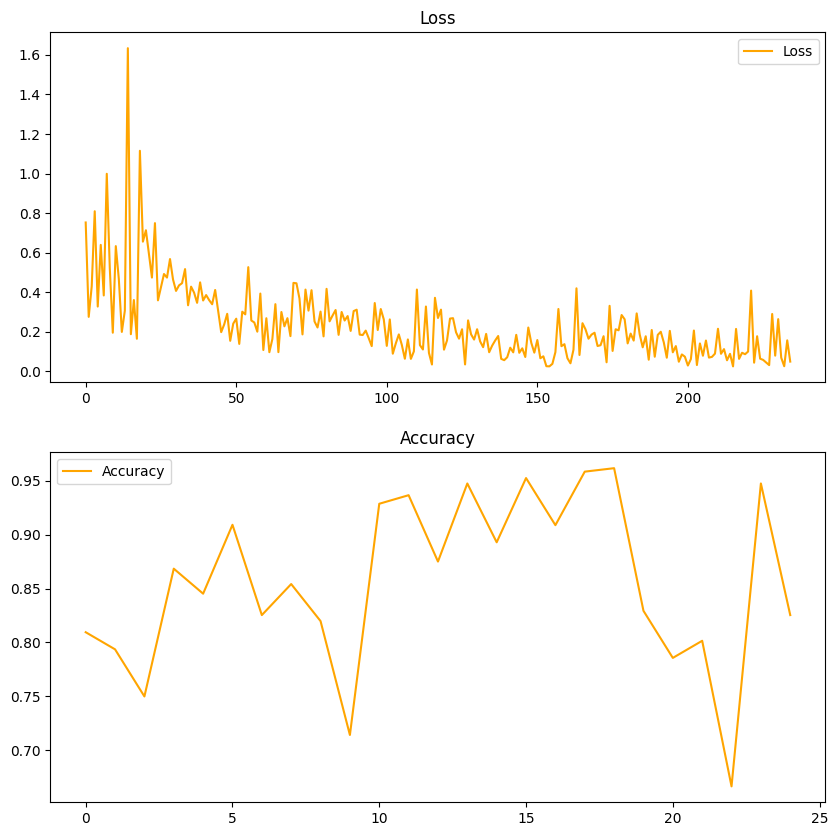

In [16]:
# loss_list, acc_list 시각화
# - acc_list와 loss_list의 길이가 다르지만 동일하게 맞추기
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(loss_list, label='Loss', color='orange')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(acc_list, label='Accuracy', color='orange')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()


In [14]:
# Test
model.eval()
with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_loader):
        
        preds = model(imgs)
        label = labels.unsqueeze(1).float()
        
        loss = criterion(preds, label)
        pred = torch.sigmoid(preds) > 0.5
        acc = multiclass_accuracy(pred, label, num_classes=3)
        
        print(f'Step [{i+1}/{len(test_loader)}], Loss : {loss.item()}, Accuracy : {acc.item()}')

Step [1/5], Loss : 0.5849651098251343, Accuracy : 0.8333333730697632
Step [2/5], Loss : 0.5120339393615723, Accuracy : 0.8181818127632141
Step [3/5], Loss : 0.9420350193977356, Accuracy : 0.7833333015441895
Step [4/5], Loss : 0.39972397685050964, Accuracy : 0.8333333730697632
Step [5/5], Loss : 0.398317813873291, Accuracy : 0.8582996129989624
